In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import statsmodels.api as sm
from scipy.stats import normaltest
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from statsmodels.stats import weightstats as stests
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
sns.set(style="whitegrid", palette="pastel", color_codes=True)    
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

#### Link to Dataset: https://www.kaggle.com/hugodarwood/epirecipes

In [2]:
df = pd.read_csv('../cleaned_epi.csv')

In [3]:
df.head(1)

,title,rating,calories,protein,fat,sodium,appetizer,dessert,dinner,low carb,low sugar,meat,vegan,vegetarian,snack,alcoholic,holidays,SqrtCalories,LogProtein,SqrtFat
0,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,20.07486,2.944439,4.795832


In [4]:
df.drop(columns='title',inplace=True)

In [5]:
df.rating.value_counts()

4.375    5419
3.750    3530
5.000    1745
3.125    1019
Name: rating, dtype: int64

In [6]:
df.dtypes

rating          float64
calories        float64
protein         float64
fat             float64
sodium          float64
appetizer       float64
dessert         float64
dinner          float64
low carb        float64
low sugar       float64
meat            float64
vegan           float64
vegetarian      float64
snack           float64
alcoholic       float64
holidays          int64
SqrtCalories    float64
LogProtein      float64
SqrtFat         float64
dtype: object

In [7]:
# create feature and target variables
X = df[['calories','protein','fat','vegetarian','holidays','sodium', 'appetizer','dessert','dinner',
       'low carb','low sugar', 'meat', 'vegan', 'snack','alcoholic']]
y = df['rating']

In [8]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 80% training and 20% test

In [9]:
lab_enc = preprocessing.LabelEncoder()
ytrain_enc = lab_enc.fit_transform(y_train)
ytest_enc = lab_enc.fit_transform(y_test)

In [10]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,ytrain_enc)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [11]:
ypred_enc = lab_enc.fit_transform(y_pred)

In [12]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(ytest_enc, ypred_enc))

Accuracy: 0.4344857020913359


This accuracy score is on the lower end, it could be improved by tuning the hyperparameters.

#### Classification Report

In [13]:
from sklearn.metrics import classification_report

print(classification_report(ytest_enc, ypred_enc))

             precision    recall  f1-score   support

          0       0.21      0.22      0.21       206
          1       0.40      0.38      0.39       706
          2       0.53      0.54      0.53      1026
          3       0.37      0.37      0.37       405

avg / total       0.43      0.43      0.43      2343



Because the target values are heavily biased toward the 4.375 rating, the f1 score will be used as the primary evaluation metric.

#### ROC Evaluation

In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

lab_enc = preprocessing.LabelEncoder()
y_enc = lab_enc.fit_transform(y)

In [33]:
# Binarize the output
y = label_binarize(y_enc, classes=[0,1,2,3])
n_classes = 4

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 80% training and 20% test

clf = DecisionTreeClassifier()

y_score = clf.fit(X_train, y_train).predict(X_test)

In [34]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [35]:
print(roc_auc['micro'])

0.6231327358087921


In [36]:
#ROC curve for a specific class here for all classes
print(roc_auc)

{0: 0.5701498334931012, 1: 0.5744171176113286, 2: 0.5782058284156354, 3: 0.61512059014639, 'micro': 0.6231327358087921}


The above output is the AUROC for each class predicted by the decision tree. 

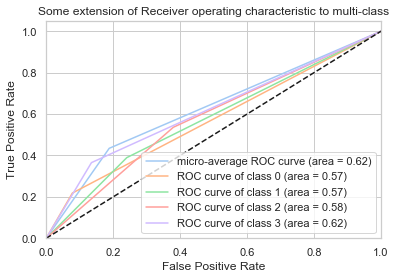

In [48]:
# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

#### Confusion Matrix

In [77]:
# redefine X and y
X = df[['calories','protein','fat','vegetarian','holidays','sodium', 'appetizer','dessert','dinner',
       'low carb','low sugar', 'meat', 'vegan', 'snack','alcoholic']]
y = df['rating']

lab_enc = preprocessing.LabelEncoder()
y_enc = lab_enc.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=1) 

clf = DecisionTreeClassifier()

clf = clf.fit(X_train,ytrain_enc)

y_pred = clf.predict(X_test)

ypred_enc = lab_enc.fit_transform(y_pred)

cm = confusion_matrix(y_test, ypred_enc)

In [78]:
print(cm)

[[ 46  62  71  27]
 [ 69 278 274  85]
 [ 82 253 547 144]
 [ 23  81 157 144]]


In [79]:
#create dataframe from confusion matrix
df_cm = pd.DataFrame(cm, index=['3.125','3.75','4.375','5.0'],
                  columns=['3.125','3.75','4.375','5.0'])

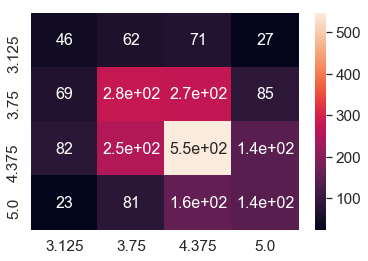

In [80]:
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

Looking at both the AUC Curve and the Confusion Matrix Heatmap, this model (without any hyperparameter tuning) does not do a good job at predicting ratings.

### Parameter Tuning - CV Grid Search

In [81]:
from sklearn.model_selection import GridSearchCV

# redefine X and y
X = df[['calories','protein','fat','vegetarian','holidays','sodium', 'appetizer','dessert','dinner',
       'low carb','low sugar', 'meat', 'vegan', 'snack','alcoholic']]
y = df['rating']

lab_enc = preprocessing.LabelEncoder()
y_enc = lab_enc.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=1) 

In [82]:
clf = DecisionTreeClassifier()

In [83]:
# Setup the hyperparameter grid
max_depths = np.linspace(1, 32, 32, endpoint=True)
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leaf = [0.001, 0.1, 1, 10, 100]
criterion = ['gini','entropy']
param_grid = {'criterion': criterion,'max_depth': max_depths,'min_samples_split': min_samples_splits, 
              'min_samples_leaf': min_samples_leaf}

In [84]:
#combine parameters with model
clf_model = GridSearchCV(clf,param_grid,scoring='f1_micro',cv=5)

In [85]:
# Fit it to the data
clf_model.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32.]), 'min_samples_split': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), 'min_samples_leaf': [0.001, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=0)

In [86]:
# Print the tuned parameter and score
print("Tuned Logistic Regression Parameters: {}".format(clf_model.best_params_))

Tuned Logistic Regression Parameters: {'criterion': 'entropy', 'max_depth': 6.0, 'min_samples_leaf': 100, 'min_samples_split': 0.1}


In [87]:
y_pred = clf_model.predict(X_test)

In [88]:
ypred_enc = lab_enc.fit_transform(y_pred)

In [89]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       206
          1       0.40      0.11      0.17       706
          2       0.45      0.91      0.60      1026
          3       0.52      0.08      0.14       405

avg / total       0.40      0.44      0.34      2343



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### PCA

Below, we will use PCA to reduce the dimensions to the 2 most important in predicting a rating.

In [90]:
X = df[['calories','protein','fat','vegetarian','holidays','sodium', 'appetizer','dessert','dinner',
       'low carb','low sugar', 'meat', 'vegan', 'snack','alcoholic']]
y = df['rating']

In [91]:
# Import PCA
from sklearn.decomposition import PCA

# Create a PCA model with 2 components: pca
pca = PCA(n_components = 2)

# Fit the PCA instance to tX
pca.fit(X)

# Transform the scaled samples: pca_features
x_pca = pca.transform(X)

In [95]:
principalDf = pd.DataFrame(data = x_pca
             , columns = ['principal component 1', 'principal component 2'])

In [96]:
finalDf = pd.concat([principalDf, df[['calories','protein','fat','vegetarian','holidays','sodium', 'appetizer','dessert','dinner',
       'low carb','low sugar', 'meat', 'vegan', 'snack','alcoholic']]], axis = 1)

In [99]:
finalDf.columns

Index(['principal component 1', 'principal component 2', 'calories', 'protein',
       'fat', 'vegetarian', 'holidays', 'sodium', 'appetizer', 'dessert',
       'dinner', 'low carb', 'low sugar', 'meat', 'vegan', 'snack',
       'alcoholic'],
      dtype='object')

In [100]:
X = finalDf[['principal component 1', 'principal component 2', 'calories', 'protein',
       'fat', 'vegetarian', 'holidays', 'sodium', 'appetizer', 'dessert',
       'dinner', 'low carb', 'low sugar', 'meat', 'vegan', 'snack',
       'alcoholic']]
y = df['rating']

In [101]:
lab_enc = preprocessing.LabelEncoder()
y_enc = lab_enc.fit_transform(y)

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=1) 
# 80% training and 20% test

In [103]:
# Create Decision Tree classifer object with best parameter values
clf = DecisionTreeClassifier(criterion= 'entropy',max_depth = 6.0, min_samples_leaf = 100,
                             min_samples_split = 0.1)

# Train Decision Tree Classifer
clf = clf.fit(X_train, ytrain_enc)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [104]:
ypred_enc = lab_enc.fit_transform(y_pred)

In [105]:
print('F1 Score',classification_report(y_test, y_pred))

F1 Score              precision    recall  f1-score   support

          0       0.00      0.00      0.00       206
          1       0.39      0.11      0.17       706
          2       0.45      0.91      0.60      1026
          3       0.52      0.08      0.14       405

avg / total       0.40      0.44      0.34      2343



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Random Forest

In [107]:
X = df[['calories','protein','fat','vegetarian','holidays','sodium', 'appetizer','dessert','dinner',
       'low carb','low sugar', 'meat', 'vegan', 'snack','alcoholic']]
y = df['rating']

In [108]:
lab_enc = preprocessing.LabelEncoder()
y_enc = lab_enc.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=1) 

In [109]:
from sklearn.ensemble import RandomForestClassifier

regressor = RandomForestClassifier(n_estimators=100, random_state=1)  
regressor.fit(X_train, y_train)  
y_pred = regressor.predict(X_test) 

In [110]:
ypred_enc = lab_enc.fit_transform(y_pred)

In [111]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(ytest_enc,ypred_enc))  
print(classification_report(ytest_enc,ypred_enc))  

[[ 33  49 113  11]
 [ 10 256 409  31]
 [ 13 210 761  42]
 [  5  63 207 130]]
             precision    recall  f1-score   support

          0       0.54      0.16      0.25       206
          1       0.44      0.36      0.40       706
          2       0.51      0.74      0.60      1026
          3       0.61      0.32      0.42       405

avg / total       0.51      0.50      0.48      2343



#### ROC Evaluation

In [114]:
# Binarize the output
y = label_binarize(y_enc, classes=[0,1,2,3])
n_classes = 4

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 80% training and 20% test

clf = RandomForestClassifier(n_estimators=100, random_state=1)

y_score = clf.fit(X_train, y_train).predict(X_test)

In [115]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

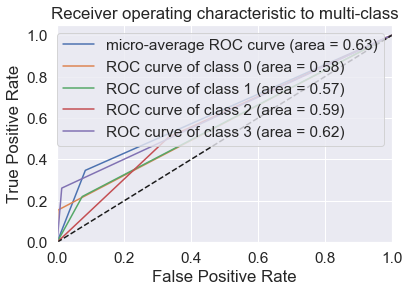

In [117]:
# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="upper right")
plt.show()

In [118]:
#ROC curve for a specific class here for all classes
print(roc_auc)

{0: 0.5765000386168797, 1: 0.572912863127984, 2: 0.5871242900975547, 3: 0.6238982532584183, 'micro': 0.6315265329349837}


With the random forest (with no parameter tuning), the roc_auc scores for each class are all slightly higher.